In [33]:
import numpy as np 
import pandas as pd 
import pytz as tz
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from warnings import filterwarnings
filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Gowalla_totalCheckins.txt/Gowalla_totalCheckins.txt', sep='\t', header=None)
df.columns = ['userid','timestamp','latitude','longitude','spotid']
df.head()

,userid,timestamp,latitude,longitude,spotid
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6442892 entries, 0 to 6442891
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userid     int64  
 1   timestamp  object 
 2   latitude   float64
 3   longitude  float64
 4   spotid     int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 245.8+ MB


In [6]:
#df.isnull().sum()

In [7]:
lon_min, lat_min, lon_max, lat_max = -74.2589, 40.4774, -73.7004, 40.9176
nyc_events = df[(df['longitude']>lon_min) & 
           (df['longitude']<lon_max) & 
           (df['latitude']>lat_min) & 
           (df['latitude']<lat_max)]
nyc_events.head()

,userid,timestamp,latitude,longitude,spotid
10,0,2010-10-12T00:21:28Z,40.643885,-73.782806,23261
11,0,2010-10-11T20:21:20Z,40.741374,-73.988105,16907
12,0,2010-10-11T20:20:42Z,40.741388,-73.989455,12973
13,0,2010-10-11T00:06:30Z,40.724910,-73.994621,341255
14,0,2010-10-10T22:00:37Z,40.729768,-73.998535,260957


In [8]:
nyc_events.shape

(138957, 5)

In [9]:
print(nyc_events.iloc[0:,4])

10          23261
11          16907
12          12973
13         341255
14         260957
            ...  
6441849     12313
6442621     23741
6442622     12535
6442623     11857
6442624     99459
Name: spotid, Length: 138957, dtype: int64


In [10]:
venues = pd.read_csv('/content/drive/MyDrive/Gowalla_totalCheckins.txt/spots.txt', sep='\t', header=0)
venues.head()

,spotid,spotname,geo-coordinates
0,1391604,Conference House Park,POINT(-74.2523431778 40.5017589436)
1,1391611,Almer G. Russell Pavilion,POINT(-74.2542636395 40.5022647413)
2,3612422,Conference House,POINT(-74.2490418254 40.5000644614)
3,3612431,Billop House,POINT(-74.2490418254 40.5000644614)
4,1391499,Biddle House,POINT(-74.2541456223 40.5054829933)


In [11]:
import pytz as tz
from datetime import datetime

In [12]:
def parse_datetime(s):
    tzone = tz.timezone("America/New_York") #parse_datetime
    utc = datetime.strptime(s, '%Y-%m-%dT%H:%M:%SZ')
    return tz.utc.localize(utc).astimezone(tzone)

In [13]:
nyc_events.iloc[:, 1 : 2]

,timestamp
10,2010-10-12T00:21:28Z
11,2010-10-11T20:21:20Z
12,2010-10-11T20:20:42Z
13,2010-10-11T00:06:30Z
14,2010-10-10T22:00:37Z
...,...
6441849,2010-08-14T19:56:43Z
6442621,2010-09-29T22:57:13Z
6442622,2010-09-29T22:56:47Z
6442623,2010-09-29T18:49:51Z


In [14]:
nyc_events['ts'] = nyc_events['timestamp'].apply(lambda x: parse_datetime(x))
nyc_events = nyc_events.drop('timestamp',axis=1,errors='ignore')

#local date and time
nyc_events['date']  = nyc_events['ts'].astype(object).apply(lambda x : x.date())
nyc_events['time']  = nyc_events['ts'].astype(object).apply(lambda x : x.time())

#day of the week (localtime)
#hour of the day (localtime)
nyc_events['weekday']  = nyc_events['date'].astype(object).apply(lambda x : x.weekday())
nyc_events['day']   = nyc_events['date'].astype(object).apply(lambda x : x.day)
nyc_events['hour']   = nyc_events['time'].astype(object).apply(lambda x : x.hour)

nyc_events[['ts','date','time','weekday','day','hour']][0:5]

,ts,date,time,weekday,day,hour
10,2010-10-11 20:21:28-04:00,2010-10-11,20:21:28,0,11,20
11,2010-10-11 16:21:20-04:00,2010-10-11,16:21:20,0,11,16
12,2010-10-11 16:20:42-04:00,2010-10-11,16:20:42,0,11,16
13,2010-10-10 20:06:30-04:00,2010-10-10,20:06:30,6,10,20
14,2010-10-10 18:00:37-04:00,2010-10-10,18:00:37,6,10,18


In [15]:
nyc_events.head(10)

,userid,latitude,longitude,spotid,ts,date,time,weekday,day,hour
10,0,40.643885,-73.782806,23261,2010-10-11 20:21:28-04:00,2010-10-11,20:21:28,0,11,20
11,0,40.741374,-73.988105,16907,2010-10-11 16:21:20-04:00,2010-10-11,16:21:20,0,11,16
12,0,40.741388,-73.989455,12973,2010-10-11 16:20:42-04:00,2010-10-11,16:20:42,0,11,16
13,0,40.724910,-73.994621,341255,2010-10-10 20:06:30-04:00,2010-10-10,20:06:30,6,10,20
14,0,40.729768,-73.998535,260957,2010-10-10 18:00:37-04:00,2010-10-10,18:00:37,6,10,18
15,0,40.728527,-73.996868,1933724,2010-10-10 17:17:14-04:00,2010-10-10,17:17:14,6,10,17
16,0,40.741747,-73.993421,105068,2010-10-10 13:47:04-04:00,2010-10-10,13:47:04,6,10,13
17,0,40.734193,-74.004164,34817,2010-10-09 19:51:10-04:00,2010-10-09,19:51:10,5,9,19
18,0,40.742512,-74.006031,27836,2010-10-09 18:27:07-04:00,2010-10-09,18:27:07,5,9,18
19,0,40.742396,-74.007543,15079,2010-10-09 17:39:26-04:00,2010-10-09,17:39:26,5,9,17


In [16]:
nyc_events = pd.DataFrame.merge(nyc_events, venues[['spotid','spotname']], on='spotid', how="inner")
nyc_events.head()

,userid,latitude,longitude,spotid,ts,date,time,weekday,day,hour,spotname
0,0,40.643885,-73.782806,23261,2010-10-11 20:21:28-04:00,2010-10-11,20:21:28,0,11,20,JFK John F. Kennedy International
1,0,40.643885,-73.782806,23261,2010-10-07 11:27:40-04:00,2010-10-07,11:27:40,3,7,11,JFK John F. Kennedy International
2,5,40.643885,-73.782806,23261,2010-08-15 23:47:20-04:00,2010-08-15,23:47:20,6,15,23,JFK John F. Kennedy International
3,8,40.643885,-73.782806,23261,2010-10-06 16:23:14-04:00,2010-10-06,16:23:14,2,6,16,JFK John F. Kennedy International
4,15,40.643885,-73.782806,23261,2010-10-13 00:10:36-04:00,2010-10-13,00:10:36,2,13,0,JFK John F. Kennedy International


In [17]:
len(nyc_events.spotid.unique())

17291

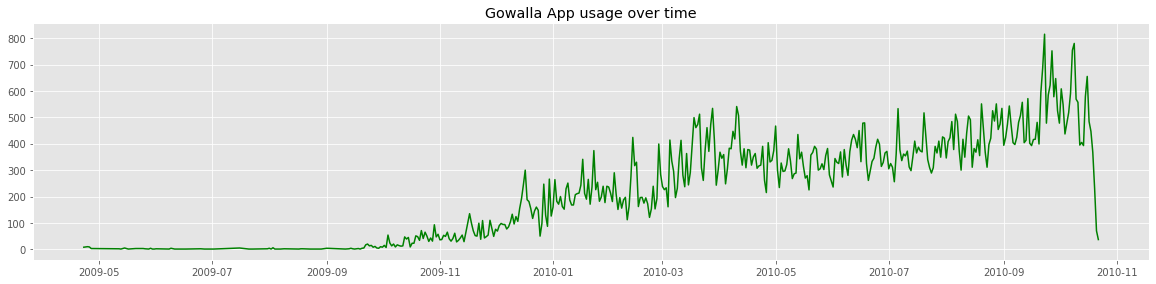

In [18]:
# Let us plot the events registered, ordered temporally by increasing timestamps and grouped by date
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 12})

plt.style.use('ggplot')

plt.subplot(4, 1, 1)
top = nyc_events.groupby('date').size()
plt.plot(top.index, top, 'g-')
plt.title('Gowalla App usage over time')
plt.show()


Text(0.5, 1.0, 'Check-ins: Hour of the day')

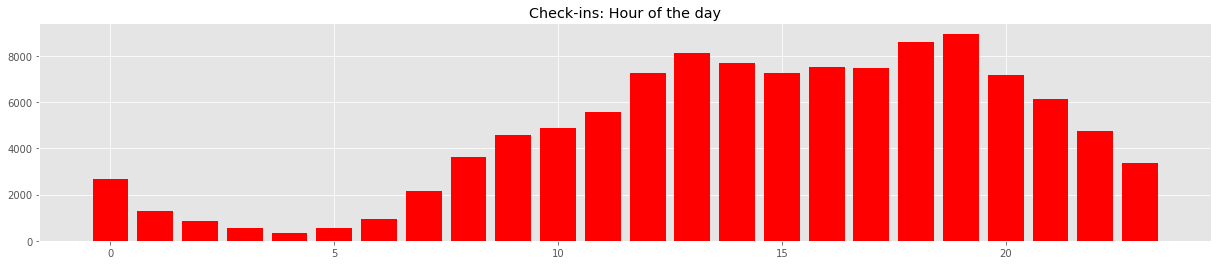

In [19]:
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21,4)
top = nyc_events.groupby('hour').size()
plt.bar(top.index, top,align='center', color='red')
plt.title('Check-ins: Hour of the day')

Text(0.5, 1.0, 'Check-ins: Day of the week')

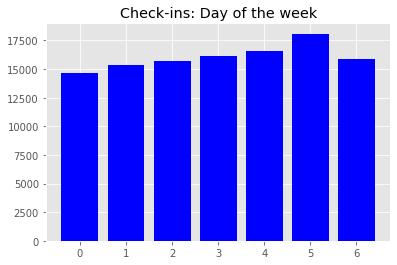

In [20]:
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21,4)
plt.subplot(1, 3, 2)
top = nyc_events.groupby('weekday').size()
plt.bar(top.index, top,align='center',color='blue')
plt.title('Check-ins: Day of the week')

Text(0.5, 1.0, 'Check-ins: Day of the month')

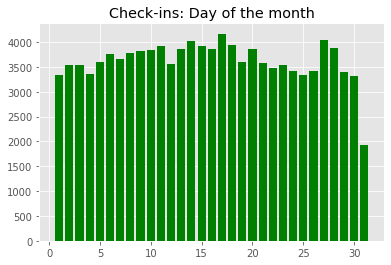

In [21]:
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21,4)
plt.subplot(1, 3, 3)
top = nyc_events.groupby('day').size()
plt.bar(top.index, top,align='center',color='green')
plt.title('Check-ins: Day of the month')

In [22]:
x1 = df['longitude'].values
y1 = df['latitude'].values

Text(0, 0.5, 'Latitude')

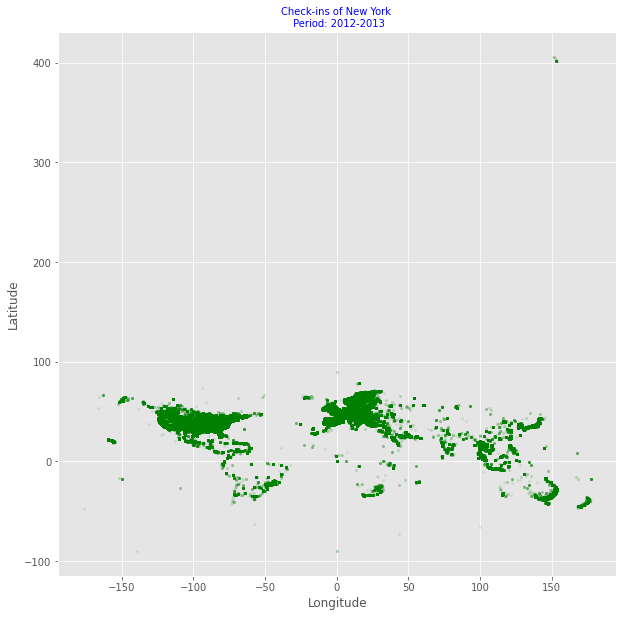

In [24]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot()
ax1.scatter(x1,y1,s=5, alpha=0.1, c='g',edgecolors=None)
  
ax1.set_title("Check-ins of New York \n Period: 2012-2013",fontsize=10,color='blue')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

In [25]:
df.describe()

,userid,latitude,longitude,spotid
count,6.442892e+06,6.442892e+06,6.442892e+06,6.442892e+06
mean,6.043642e+04,4.052177e+01,-4.744338e+01,7.257161e+05
std,5.427504e+04,1.476714e+01,6.636130e+01,9.501359e+05
min,0.000000e+00,-9.000000e+01,-1.763086e+02,8.904000e+03
25%,1.104800e+04,3.340766e+01,-9.767548e+01,1.125330e+05
50%,4.229500e+04,3.988993e+01,-7.806955e+01,4.249405e+05
75%,1.071570e+05,5.125089e+01,1.113241e+01,9.775450e+05
max,1.965850e+05,4.056585e+02,1.774625e+02,5.977757e+06


In [26]:
corr=df.corr()

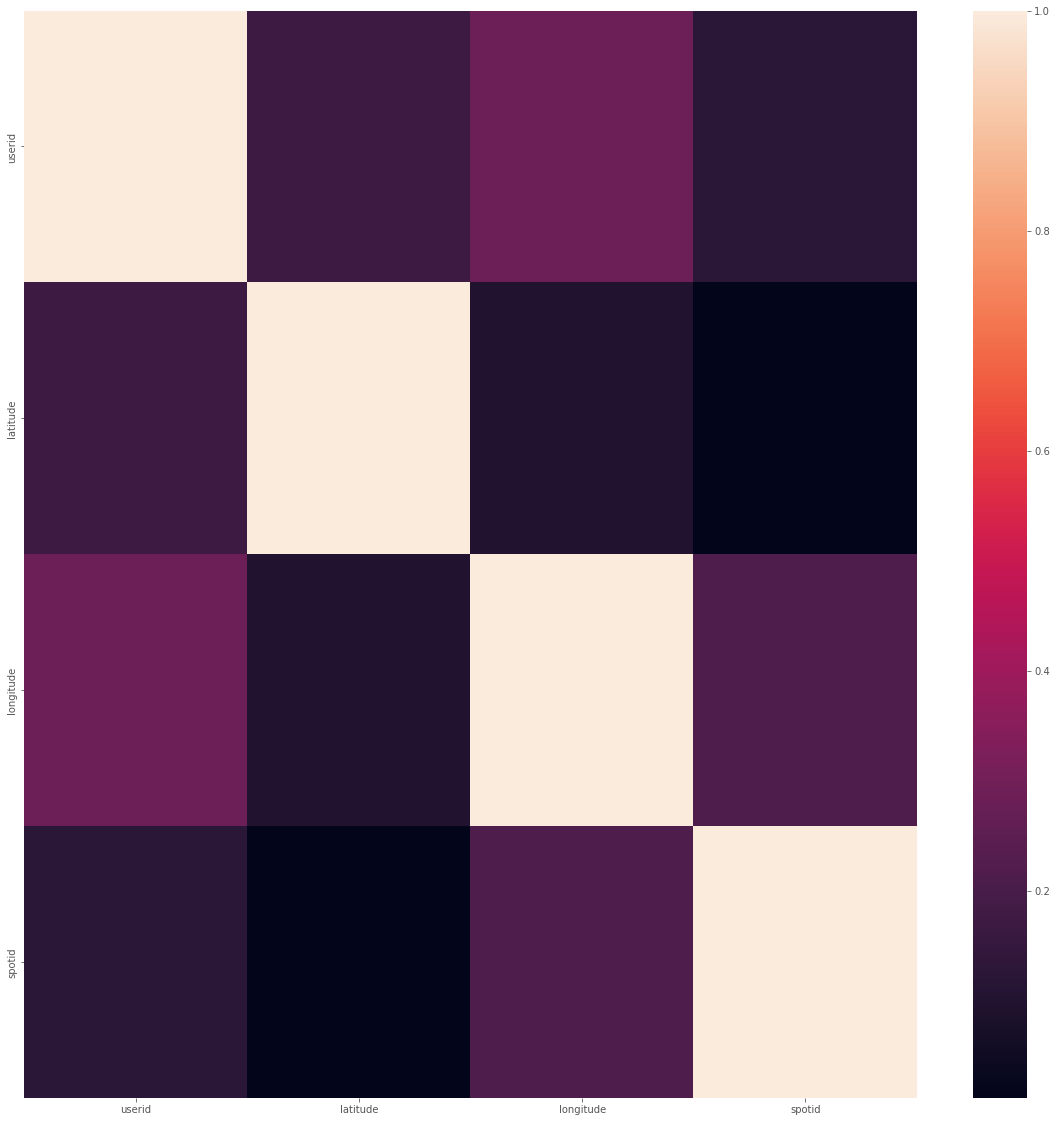

In [28]:
import seaborn as sns
sns.heatmap(corr)

In [34]:
kmeans=KMeans(n_clusters=240, init='k-means++')

In [35]:
kmeans = KMeans(n_clusters=240, init='k-means++')

# Compute the clusters based on longitude and latitude features
X_sample = nyc_events[['longitude','latitude']].sample(frac=0.1)
kmeans.fit(X_sample)
y = kmeans.labels_
print("k = 240", " silhouette_score ", silhouette_score(X_sample, y, metric='euclidean'))

k = 240  silhouette_score  0.47104714613547083


In [36]:
nyc_events['cluster'] = kmeans.predict(nyc_events[['longitude','latitude']])
nyc_events[['userid','latitude','longitude','spotid','cluster']].sample(10)

,userid,latitude,longitude,spotid,cluster
98872,12825,40.738947,-73.999284,184304,201
43298,46186,40.800751,-73.828983,92390,109
100276,16581,40.895672,-74.160477,383608,151
44246,11372,40.725013,-74.002380,1036038,5
99431,14851,40.720728,-73.846417,942649,200
88875,82885,40.720546,-73.984890,548505,118
102981,72198,40.746144,-74.159983,1603959,19
110610,104357,40.726026,-73.994944,2680064,148
42649,12617,40.721069,-73.987727,51896,118
42084,285,40.722816,-74.001384,21639,5


In [37]:
nyc_events['cluster'].unique()

array([  9, 122, 148, 202,  31, 184,  81,  38, 127,  21, 159, 211,  23,
       153,  13, 216, 235,  40, 223, 146,  95, 139, 162,  96, 205, 185,
       134,  14, 174, 118, 133,   8, 234, 201,  94, 212, 106,  68,   3,
       186,  39, 226, 104, 180, 144,  67,  80,  22, 237, 129,  50,  66,
        86, 191, 121, 218, 171,   5, 113, 164,  83, 189,  32, 196,  35,
       239, 220, 199, 167,  99,  12,   4,  74, 147,   0, 238, 105, 125,
        51,  70, 157, 100, 175, 168,  91, 173,  69,  55, 197, 138, 172,
       120,  60, 115,  43, 108, 160, 166, 128,  88,  15, 161,  48,  58,
        57,  87,  10, 150,  92, 194, 209,  29,  19,  84, 193,  89,  45,
       231,  20, 143, 109,  53,   2, 152,  54, 101,  44, 187, 236, 198,
       132, 107,  77, 177, 232,  28, 222, 137, 179, 123,  98,  85,  72,
        75, 195,  17, 130, 131, 135, 210, 176, 116, 124,  34,  76, 227,
       163, 149, 182,  73, 203, 110,  24, 114, 188,  63,  61,  27, 169,
        56,   6,  36,  46,  18,  64, 181, 233,   7,  82,  65,   

In [38]:
gdf = nyc_events.groupby(['cluster', 'spotid']).size().reset_index()
gdf.columns = ['cluster', 'spotid', 'count']
idx = gdf.groupby(['cluster'])['count'].transform(max) == gdf['count']
topvenues_df = gdf[idx].merge(venues, on='spotid', how='left').sort_values(by='count', ascending=False)
#top 10 out of 200 clusters by events count
topvenues = topvenues_df[:10]

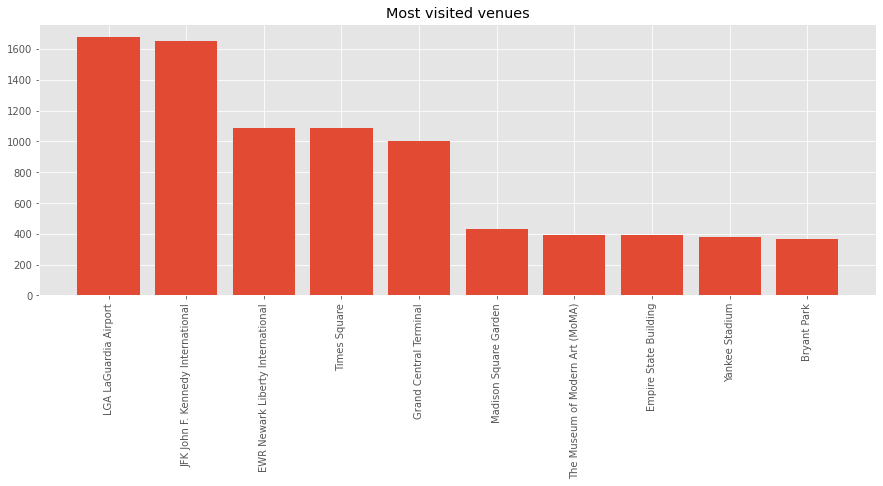

In [39]:
# Most Visited Venues
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(15,5)

plt.bar(range(len(topvenues)), topvenues['count'], align='center')
plt.xticks(range(len(topvenues)),topvenues['spotname'], rotation='vertical')
plt.title('Most visited venues')
plt.show()

In [40]:
def recommend_venues(df, longitude, latitude):
    predicted_cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    # Fetch the venue name of the top most record in the topvenues dataframe for the predicted cluster
    venue_name = df[df['cluster']==predicted_cluster].iloc[0]['spotname']
    msg = 'What about visiting the ' + venue_name + '?'
    return msg

In [41]:
recommend_venues(topvenues_df, -74, 40.55)

'What about visiting the Coney Island Boardwalk?'

In [42]:
recommend_venues(topvenues_df, -73.993, 40.75)

'What about visiting the Madison Square Garden?'

In [43]:
kmeans.predict([[-74, 40.55]])

array([27], dtype=int32)

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import f1_score,precision_score,recall_score,precision_recall_curve,accuracy_score,classification_report,plot_precision_recall_curve

In [45]:
#df=nyc_events.drop(['ts','time','date','weekday','day','hour','spotname'], axis=1)
#df.head()

In [46]:
nyc_events.drop(['ts'],axis=1,inplace=True)

In [48]:
 #X = nyc_events.drop(['spotid'],axis=1)
 #y = nyc_events.spotid

In [49]:
nyc_events

,userid,latitude,longitude,spotid,date,time,weekday,day,hour,spotname,cluster
0,0,40.643885,-73.782806,23261,2010-10-11,20:21:28,0,11,20,JFK John F. Kennedy International,9
1,0,40.643885,-73.782806,23261,2010-10-07,11:27:40,3,7,11,JFK John F. Kennedy International,9
2,5,40.643885,-73.782806,23261,2010-08-15,23:47:20,6,15,23,JFK John F. Kennedy International,9
3,8,40.643885,-73.782806,23261,2010-10-06,16:23:14,2,6,16,JFK John F. Kennedy International,9
4,15,40.643885,-73.782806,23261,2010-10-13,00:10:36,2,13,0,JFK John F. Kennedy International,9
...,...,...,...,...,...,...,...,...,...,...,...
112385,194967,40.823098,-74.219366,865373,2010-08-03,20:26:18,1,3,20,Quik Check,92
112386,195787,40.737428,-74.004173,1042049,2010-05-18,22:52:14,1,18,22,Coopy's Den,201
112387,195787,40.737428,-74.004173,1042049,2010-04-30,20:34:10,4,30,20,Coopy's Den,201
112388,195789,40.726720,-73.986155,16965,2010-10-20,20:04:03,2,20,20,Counter,127


In [50]:
#X.head()

In [51]:
#nyc_events.head()

In [52]:
nyc_events.drop(['date','time'],axis=1,inplace=True)

In [53]:
nyc_events.head()

,userid,latitude,longitude,spotid,weekday,day,hour,spotname,cluster
0,0,40.643885,-73.782806,23261,0,11,20,JFK John F. Kennedy International,9
1,0,40.643885,-73.782806,23261,3,7,11,JFK John F. Kennedy International,9
2,5,40.643885,-73.782806,23261,6,15,23,JFK John F. Kennedy International,9
3,8,40.643885,-73.782806,23261,2,6,16,JFK John F. Kennedy International,9
4,15,40.643885,-73.782806,23261,2,13,0,JFK John F. Kennedy International,9


In [54]:
nyc_events["spotname"].unique()

array(['JFK John F. Kennedy International', 'Shake Shack',
       'Flatiron Building ', ..., "Coopy's Den", 'Counter', 'PHA'],
      dtype=object)

In [55]:
nyc_events["spotname"].nunique()

14459

In [58]:
nyc_events["spotid"].nunique()

17291

In [59]:
nyc_events["spotname"]=nyc_events["spotname"].astype("str")

In [61]:
#nyc_events = nyc_events.drop(['spotname'],axis=1)

In [60]:
nyc_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112390 entries, 0 to 112389
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userid     112390 non-null  int64  
 1   latitude   112390 non-null  float64
 2   longitude  112390 non-null  float64
 3   spotid     112390 non-null  int64  
 4   weekday    112390 non-null  int64  
 5   day        112390 non-null  int64  
 6   hour       112390 non-null  int64  
 7   spotname   112390 non-null  object 
 8   cluster    112390 non-null  int32  
dtypes: float64(2), int32(1), int64(5), object(1)
memory usage: 8.1+ MB


In [65]:
nyc_events.iloc[:,-1]

0           9
1           9
2           9
3           9
4           9
         ... 
112385     92
112386    201
112387    201
112388    127
112389    189
Name: cluster, Length: 112390, dtype: int32

In [66]:
nyc_events.head(-50)

,userid,latitude,longitude,spotid,weekday,day,hour,spotname,cluster
0,0,40.643885,-73.782806,23261,0,11,20,JFK John F. Kennedy International,9
1,0,40.643885,-73.782806,23261,3,7,11,JFK John F. Kennedy International,9
2,5,40.643885,-73.782806,23261,6,15,23,JFK John F. Kennedy International,9
3,8,40.643885,-73.782806,23261,2,6,16,JFK John F. Kennedy International,9
4,15,40.643885,-73.782806,23261,2,13,0,JFK John F. Kennedy International,9
...,...,...,...,...,...,...,...,...,...
112335,185595,40.832577,-74.158099,254283,1,22,18,Torino North,137
112336,186075,40.675973,-73.980904,1497213,0,18,11,Bob And Judi's Coolectibles,85
112337,186534,40.704507,-74.017268,1894639,0,16,13,New York Downtown Marriot International,91
112338,186629,40.775558,-73.950106,752329,2,30,13,Peters,167


In [63]:
print(nyc_events["spotid"]==1497213)

0         False
1         False
2         False
3         False
4         False
          ...  
112385    False
112386    False
112387    False
112388    False
112389    False
Name: spotid, Length: 112390, dtype: bool


In [62]:
print('There are {} uniques categories.'.format(len(nyc_events['spotname'].unique())))
nyc_events.groupby('spotname')['spotname'].count().sort_values(ascending=False)

There are 14459 uniques categories.


spotname
LGA LaGuardia Airport                1680
JFK John F. Kennedy International    1654
Starbucks                            1321
Starbucks Coffee                     1115
EWR Newark Liberty International     1089
                                     ... 
MMM Bello's Pub                         1
MLA                                     1
MET Foods                               1
MECHS2                                  1
Leo's Latticini                         1
Name: spotname, Length: 14459, dtype: int64

In [80]:
venue_checkins  = nyc_events.groupby("spotid")["userid"].count()

In [70]:
venue_checkins

spotid
8904        12
8932        16
8936        12
8938       130
8947       570
          ... 
5975123      1
5976149      1
5976173      1
5977211      1
5977757      1
Name: userid, Length: 1280969, dtype: int64

In [81]:
less_than10_check = venue_checkins[venue_checkins<10].index

In [82]:
len(less_than10_check)

14838

In [83]:
nyc_events = nyc_events[~nyc_events["spotid"].isin(less_than10_check)]
nyc_events.shape

(68000, 9)

In [89]:
#nyc_events[nyc_events["spotid"]=="254283"]

In [90]:
#nyc_events[["latitude","longitude"]].drop_duplicates().shape

In [91]:
#nyc_events[nyc_events["spotname"] == "Torino North"]["spotid"].unique()

In [95]:
for x in nyc_events.spotname.unique():
    if nyc_events[nyc_events["spotname"] == x].spotid.nunique()>10:
        del(x)

In [97]:
print('There are {} uniques categories.'.format(len(nyc_events['spotname'].unique())))
nyc_events.groupby('spotname')['spotname'].count().sort_values(ascending=False)

There are 2222 uniques categories.


spotname
LGA LaGuardia Airport                1680
JFK John F. Kennedy International    1654
EWR Newark Liberty International     1089
Times Square                         1089
Starbucks                            1022
                                     ... 
Brooklyn Historical Society            10
Hanks                                  10
The Gate                               10
Hampton Inn                            10
Curry in a Hurry                       10
Name: spotname, Length: 2222, dtype: int64

In [98]:
nyc_events=nyc_events.head(15000)

In [99]:
print('There are {} uniques categories.'.format(len(nyc_events['spotname'].unique())))
nyc_events.groupby('spotname')['spotname'].count().sort_values(ascending=False)

There are 152 uniques categories.


spotname
LGA LaGuardia Airport                1680
JFK John F. Kennedy International    1654
Times Square                         1089
EWR Newark Liberty International     1089
Grand Central Terminal               1005
                                     ... 
Grassroots Tavern                      10
Duane Reade                            10
Fresco 57                              10
St. Regis Hotel                        10
Theater Row                            10
Name: spotname, Length: 152, dtype: int64

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state=10)

In [101]:
X = nyc_events.iloc[:,1:7]
y = nyc_events.iloc[:,7]

In [102]:
y

0        JFK John F. Kennedy International
1        JFK John F. Kennedy International
2        JFK John F. Kennedy International
3        JFK John F. Kennedy International
4        JFK John F. Kennedy International
                       ...                
15508                 CBS Broadcast Center
15509                 CBS Broadcast Center
15510                 CBS Broadcast Center
15511                 CBS Broadcast Center
15512                 CBS Broadcast Center
Name: spotname, Length: 15000, dtype: object

In [104]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [105]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [106]:
knn.score(X_test, y_test)

0.984

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
y_pred

array(['The Standard Grill', 'VaynerMedia HQ', 'Mario Pizza', ...,
       'Loreley Williamsburg', 'Terminal 1 at JFK',
       'Radio City Music Hall'], dtype=object)

In [ ]:
X_test

,latitude,longitude,spotid,weekday,day,hour
42258,40.740795,-74.007736,144944,2,28,18
35189,40.723657,-74.008809,179980,2,1,8
97184,40.763373,-73.981698,479843,1,10,21
19781,40.735721,-73.989997,441925,6,11,17
60079,40.759317,-73.984377,926885,6,5,9
...,...,...,...,...,...,...
24382,40.715275,-74.010253,72882,3,9,12
36883,40.730576,-73.992437,444082,6,6,12
74174,40.747319,-73.985150,1256936,3,16,14
32688,40.643155,-73.789753,60201,0,28,23


In [ ]:
y_test

42258           The Standard Grill
35189               VaynerMedia HQ
97184              Stage Star Deli
19781         Marquis De Lafayette
60079             Starbucks Coffee
                   ...            
24382                    Warren 77
36883    Eighth Street—NYU Station
74174                 Empire Pizza
32688            Terminal 1 at JFK
30863        Radio City Music Hall
Name: spotname, Length: 22478, dtype: object

In [ ]:
accuracy_train = knn.score(X_train, y_train)
accuracy_test = knn.score(X_test, y_test)

print(f"Score on training set: {accuracy_train}")
print(f"Score on test set: {accuracy_test}")

Score on training set: 0.8631439629860308
Score on test set: 0.7790728712518907


In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[2 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


In [ ]:
print(classification_report(y_test,knn.predict(X_test)))

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                       precision    recall  f1-score   support

                                                   'S' Building (MEC)       0.50      1.00      0.67         2
                                                           'Wichcraft       0.33      1.00      0.50         1
                                                             'inoteca       1.00      1.00      1.00         1
                                                               'sNice       0.80      1.00      0.89         8
                                                           'wichcraft       0.92      0.75      0.83        16
                                                          'wichcraft        0.00      0.00      0.00         1
                                        - USL - Union Square Lounge -       0.00      0.00      0.00         1
                                                      1 Centre Street       1.00      1.00      1.00         1


In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)

In [ ]:
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
'S' Building (MEC),0.500000,1.000000,0.666667,2.000000
'Wichcraft,0.333333,1.000000,0.500000,1.000000
'inoteca,1.000000,1.000000,1.000000,1.000000
'sNice,0.800000,1.000000,0.888889,8.000000
'wichcraft,0.923077,0.750000,0.827586,16.000000
...,...,...,...,...
Łomżynianka,1.000000,1.000000,1.000000,1.000000
"‘inoteca, liquori",1.000000,1.000000,1.000000,1.000000
accuracy,0.779073,0.779073,0.779073,0.779073
macro avg,0.463529,0.518273,0.476698,22478.000000


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(truth, pred, average="macro"):

    lb = LabelBinarizer()
    lb.fit(truth)

    truth = lb.transform(truth)
    pred = lb.transform(pred)

    return roc_auc_score(truth, pred, average=average)

In [ ]:
y_pred_proba = knn.predict_proba(X_test)

In [ ]:
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro")) 
print(f1_score(y_test, y_pred, average="macro"))
multiclass_roc_auc_score(y_test,y_pred,average="macro")

0.46352891807056257
0.5182728321905274
0.476697970366669


0.7958210201404022

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
dt.score(X_test, y_test)

0.9071091734140048

In [ ]:
accuracy_train = dt.score(X_train, y_train)
accuracy_test = dt.score(X_test, y_test)
print(f"Score on training set: {accuracy_train}")
print(f"Score on test set: {accuracy_test}")

MemoryError: Unable to allocate 9.10 GiB for an array with shape (89912, 1, 13590) and data type float64

In [ ]:
y_predict = dt.predict(X_test)

In [ ]:
y_predict

In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, y_predict))

In [ ]:
print(classification_report(y_test,dt.predict(X_test)))

In [ ]:
print(precision_score(y_test, y_predict, average="macro"))
print(recall_score(y_test, y_predict, average="macro"))
print(f1_score(y_test, y_predict, average="macro"))
print(multiclass_roc_auc_score(y_test,y_predict,average="macro"))

0.47743696762642734
0.5473566763835417
0.4972978203940662
0.8070670910233543


# GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
GN = GaussianNB()
GN.fit(X_train, y_train)

In [ ]:
GN.score(X_test, y_test)

In [ ]:
accuracy_train = dt.score(X_train, y_train)
accuracy_test = dt.score(X_test, y_test)
print(f"Score on training set: {accuracy_train}")
print(f"Score on test set: {accuracy_test}")

In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, y_predict))

In [ ]:
print(classification_report(y_test,dt.predict(X_test)))

In [ ]:
y_predict = GN.predict(X_test)

In [ ]:
print(precision_score(y_test, y_predict, average="macro"))
print(recall_score(y_test, y_predict, average="macro"))
print(f1_score(y_test, y_predict, average="macro"))
print(multiclass_roc_auc_score(y_test,y_predict,average="macro"))

# LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr =  LogisticRegression()


lr.fit(X_train, y_train)
lr.score(X_train, y_train)

In [ ]:
accuracy_train = lr.score(X_train, y_train)
accuracy_test = lr.score(X_test, y_test)

print(f"Score on training set: {accuracy_train}")
print(f"Score on test set: {accuracy_test}")

In [ ]:
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

In [ ]:
predictions = lr.predict(X_test)

print(classification_report(y_test, predictions))

In [ ]:
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro")) 
print(multiclass_roc_auc_score(y_test,y_pred,average="macro"))

# RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
random_forest = RandomForestClassifier(max_depth=20, random_state=42)
random_forest.fit(X_train, y_train)

In [ ]:
random_forest.score(X_test, y_test)

In [ ]:
y_predict = random_forest.predict(X_test)
accuracy_score(y_test, y_predict)

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

In [ ]:
predictions = random_forest.predict(X_test)

print(classification_report(y_test, predictions))

In [ ]:
print(precision_score(y_test, y_predict, average="macro"))
print(recall_score(y_test, y_predict, average="macro"))
print(f1_score(y_test, y_predict, average="macro"))
print(multiclass_roc_auc_score(y_test,y_pred,average="macro"))

# RidgeClassifier

In [ ]:
from sklearn.linear_model import RidgeClassifier
ridge = RidgeClassifier(alpha=2.0, solver='auto')
ridge.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_predict = ridge.predict(X_test)
accuracy_score(y_test, y_predict)

In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, y_predict))

In [ ]:
predictions = ridge.predict(X_test)

print(classification_report(y_test, predictions))

In [ ]:
print(precision_score(y_test, y_predict, average="macro"))
print(recall_score(y_test, y_predict, average="macro"))
print(f1_score(y_test, y_predict, average="macro"))
print(multiclass_roc_auc_score(y_test,y_pred,average="macro"))

#  MLPClassifier

In [ ]:
from sklearn.neural_network import MLPClassifier
neural = MLPClassifier(hidden_layer_sizes=(200, ), activation='logistic', alpha=0.001, learning_rate='adaptive')
neural.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_predict = neural.predict(X_test)
accuracy_score(y_test, y_predict)

In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, y_predict))

In [ ]:
predictions = neural.predict(X_test)

print(classification_report(y_test, predictions))

In [ ]:
predictions = neural.predict(X_test)

print(classification_report(y_test, predictions))

# GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

In [ ]:
print(f1_score(y_test, predictions, average="macro"))
print(precision_score(y_test, predictions, average="macro"))
print(recall_score(y_test, predictions, average="macro")) 
print(multiclass_roc_auc_score(y_test,predictions,average="macro"))

# XGBClassifier

In [ ]:
from xgboost import XGBClassifier

In [ ]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [ ]:
print("Classification Report")
print(classification_report(y_test, y_pred))

In [ ]:
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro")) 
print(multiclass_roc_auc_score(y_test,y_pred,average="macro"))

# CategoricalNB

In [ ]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

In [ ]:
encoder = OrdinalEncoder()
data_encoded = encoder.fit_transform(df4[f_name])
df_encoded = pd.DataFrame(data_encoded, columns=f_name)
encoder = LabelEncoder()
target_encoded = encoder.fit_transform(df4['venueCategory'])
df_encoded['venueCategory'] = target_encoded

In [ ]:
X=X.astype(float)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
encoded_Y

In [ ]:
dummies = pd.get_dummies(encoded_Y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,encoded_Y, test_size=0.3, random_state=143)

In [ ]:
cnb = CategoricalNB()
cnb.fit(X_train, y_train)

In [ ]:
score=cnb.score(X_test, y_test)
score

In [ ]:
y_pred= cnb.predict(X_test)

In [ ]:
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro")) 
print(multiclass_roc_auc_score(y_test,y_pred,average="macro"))

#LSTM

In [107]:
df_lstm=nyc_events

In [108]:
df_lstm.head()

,userid,latitude,longitude,spotid,weekday,day,hour,spotname,cluster
0,0,40.643885,-73.782806,23261,0,11,20,JFK John F. Kennedy International,9
1,0,40.643885,-73.782806,23261,3,7,11,JFK John F. Kennedy International,9
2,5,40.643885,-73.782806,23261,6,15,23,JFK John F. Kennedy International,9
3,8,40.643885,-73.782806,23261,2,6,16,JFK John F. Kennedy International,9
4,15,40.643885,-73.782806,23261,2,13,0,JFK John F. Kennedy International,9


In [110]:
df_lstm.shape

(15000, 9)

In [111]:
data = df_lstm[["spotname","latitude","longitude"]]

In [112]:
data['Lat,Long'] = data[['latitude', 'longitude']].apply(tuple, axis=1)

In [114]:
data=data.drop(["latitude","longitude"],axis=1,inplace=False)

In [115]:
df_lstm['geohash'] = ""

In [116]:
target=df_lstm["spotname"]

In [117]:
!pip install pygeohash

  Created wheel for pygeohash: filename=pygeohash-1.2.0-py2.py3-none-any.whl size=6167 sha256=e42b397949fdcd368aecb8d51a45dac148d795fad019cb0d2946a51ae45ab59a
  Stored in directory: /root/.cache/pip/wheels/e2/ed/86/be7141d743cfb4aebac76406187154cd78fe9e6535d872187a
Successfully built pygeohash


In [118]:
import pygeohash as pgh

In [119]:
for index,row in df_lstm.iterrows():
            value = pgh.encode(row['latitude'],row['longitude'], precision=5)
            df_lstm.at[index,"geohash"]=value

In [120]:
var_mod = df_lstm[["spotname","geohash"]]

In [121]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()

In [122]:
for i in var_mod:
    df_lstm[i] = LE.fit_transform(df_lstm[i])

In [123]:
print('There are {} uniques categories.'.format(len(df_lstm['geohash'].unique())))
df_lstm.groupby('geohash')['geohash'].count().sort_values(ascending=False)

There are 10 uniques categories.


geohash
6    7870
9    1979
8    1680
4    1224
0    1089
2     594
1     299
5     150
7      73
3      42
Name: geohash, dtype: int64

In [124]:
print(df_lstm['spotname'].nunique())

152


In [125]:
df_lstm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 15512
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userid     15000 non-null  int64  
 1   latitude   15000 non-null  float64
 2   longitude  15000 non-null  float64
 3   spotid     15000 non-null  int64  
 4   weekday    15000 non-null  int64  
 5   day        15000 non-null  int64  
 6   hour       15000 non-null  int64  
 7   spotname   15000 non-null  int64  
 8   cluster    15000 non-null  int32  
 9   geohash    15000 non-null  int64  
dtypes: float64(2), int32(1), int64(7)
memory usage: 1.7 MB


In [126]:
df_lstm.drop(labels=['latitude','longitude','userid','cluster'],axis=1,inplace=True)

In [127]:
df_lstm.head()

,spotid,weekday,day,hour,spotname,geohash
0,23261,0,11,20,63,9
1,23261,3,7,11,63,9
2,23261,6,15,23,63,9
3,23261,2,6,16,63,9
4,23261,2,13,0,63,9


In [129]:
def swap_columns(df1, geohash, spotname):
    df['temp'] = df[geohash]
    df[geohash] = df[spotname]
    df[spotname] = df['temp']
    df.drop(columns=['temp'], inplace=True)

In [130]:
df1=df_lstm.head(15000)

In [131]:
columns_titles = ["spotid","weekday","day","hour","geohash","spotname"]

In [132]:
df1=df1[columns_titles]

In [133]:
from sklearn.model_selection import train_test_split

In [134]:
df1.head()

,spotid,weekday,day,hour,geohash,spotname
0,23261,0,11,20,9,63
1,23261,3,7,11,9,63
2,23261,6,15,23,9,63
3,23261,2,6,16,9,63
4,23261,2,13,0,9,63


In [135]:
df1=df1.values

In [140]:
#X=df_lstm.iloc[:,[0,1,2,3,5]].values

In [136]:
X = df1[:,1:5].astype(float)
Y = df1[:,0]

In [139]:
from tensorflow.keras import utils as np_utils

In [ ]:
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(Y)

In [ ]:
dummy_y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,dummy_y, test_size=0.33,random_state=2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense,Dropout, Activation, Flatten
from keras.regularizers import L2

In [ ]:
ndim = X.shape[1]

In [ ]:
embed_dim = 300
lstm_out = 80
batch_size = 128

model = Sequential()
model.add(Embedding(250, embed_dim,input_length = X.shape[1],embeddings_regularizer="l2"))
model.add(LSTM(lstm_out))
model.add(Dropout(0.2))
model.add(Dense(247,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

In [ ]:
history = model.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 2, validation_data = (X_test,y_test))

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = 128)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()